In [1]:
import catboost as cb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('card_transactions.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364342 entries, 0 to 364341
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         364342 non-null  int64  
 1   payment_id                         364342 non-null  int64  
 2   client_id                          364342 non-null  int64  
 3   transaction_date                   364342 non-null  object 
 4   amount_usd                         364342 non-null  float64
 5   card_scheme                        364342 non-null  object 
 6   fraud                              364342 non-null  int64  
 7   mcc                                364342 non-null  object 
 8   transaction_lever                  364342 non-null  int64  
 9   country_code                       364342 non-null  object 
 10  issue_bank_code                    364342 non-null  float64
 11  card_type                          3643

In [4]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [5]:
# transaction date un taze columnlar doretdim, haysy aya hepdan gunine dushyandiklerini gormek un
# we are splitting transaction date column to learn more informations from time of transaction
df['month'] = df['transaction_date'].dt.month
df['day_of_week'] = df['transaction_date'].dt.day_of_week
df["day"] = df["transaction_date"].dt.day
df["hour"] = df["transaction_date"].dt.hour
df["minute"] = df["transaction_date"].dt.minute

In [6]:
df.head()

,Unnamed: 0,payment_id,client_id,transaction_date,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,...,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed,month,day_of_week,day,hour,minute
0,17,17,384,2019-01-02 00:04:28,100.00,mastercard,0,finance,3,country_87.0,...,0.0,0.0,0.0,0.0,NaN,1,2,2,0,4
1,19,19,384,2019-01-02 00:05:30,186.00,visa,0,retail,1,country_87.0,...,2.0,0.0,NaN,0.0,0.007247,1,2,2,0,5
2,27,27,688,2019-01-02 00:09:32,47.95,visa,0,retail,3,country_87.0,...,0.0,0.0,NaN,0.0,0.207419,1,2,2,0,9
3,28,28,688,2019-01-02 00:09:33,20.00,mastercard,0,retail,2,country_87.0,...,0.0,0.0,NaN,50.0,0.022936,1,2,2,0,9
4,29,29,695,2019-01-02 00:09:39,36.99,visa,0,retail,2,country_87.0,...,0.0,0.0,NaN,0.0,0.036342,1,2,2,0,9


In [7]:
df = df.drop(columns=["transaction_date", "Unnamed: 0", "payment_id"])
# transaction datein indi geregi yok, beyleki iki sutunin correlationi uly bolany un ayyrdym
#from now on we dont need transaction date column, because we get all information from it, and also unnamed, payment_id and cleint_it columns have corellation 1, thats why we dont need all of them

In [8]:
df.shape

(364342, 42)

<Axes: >

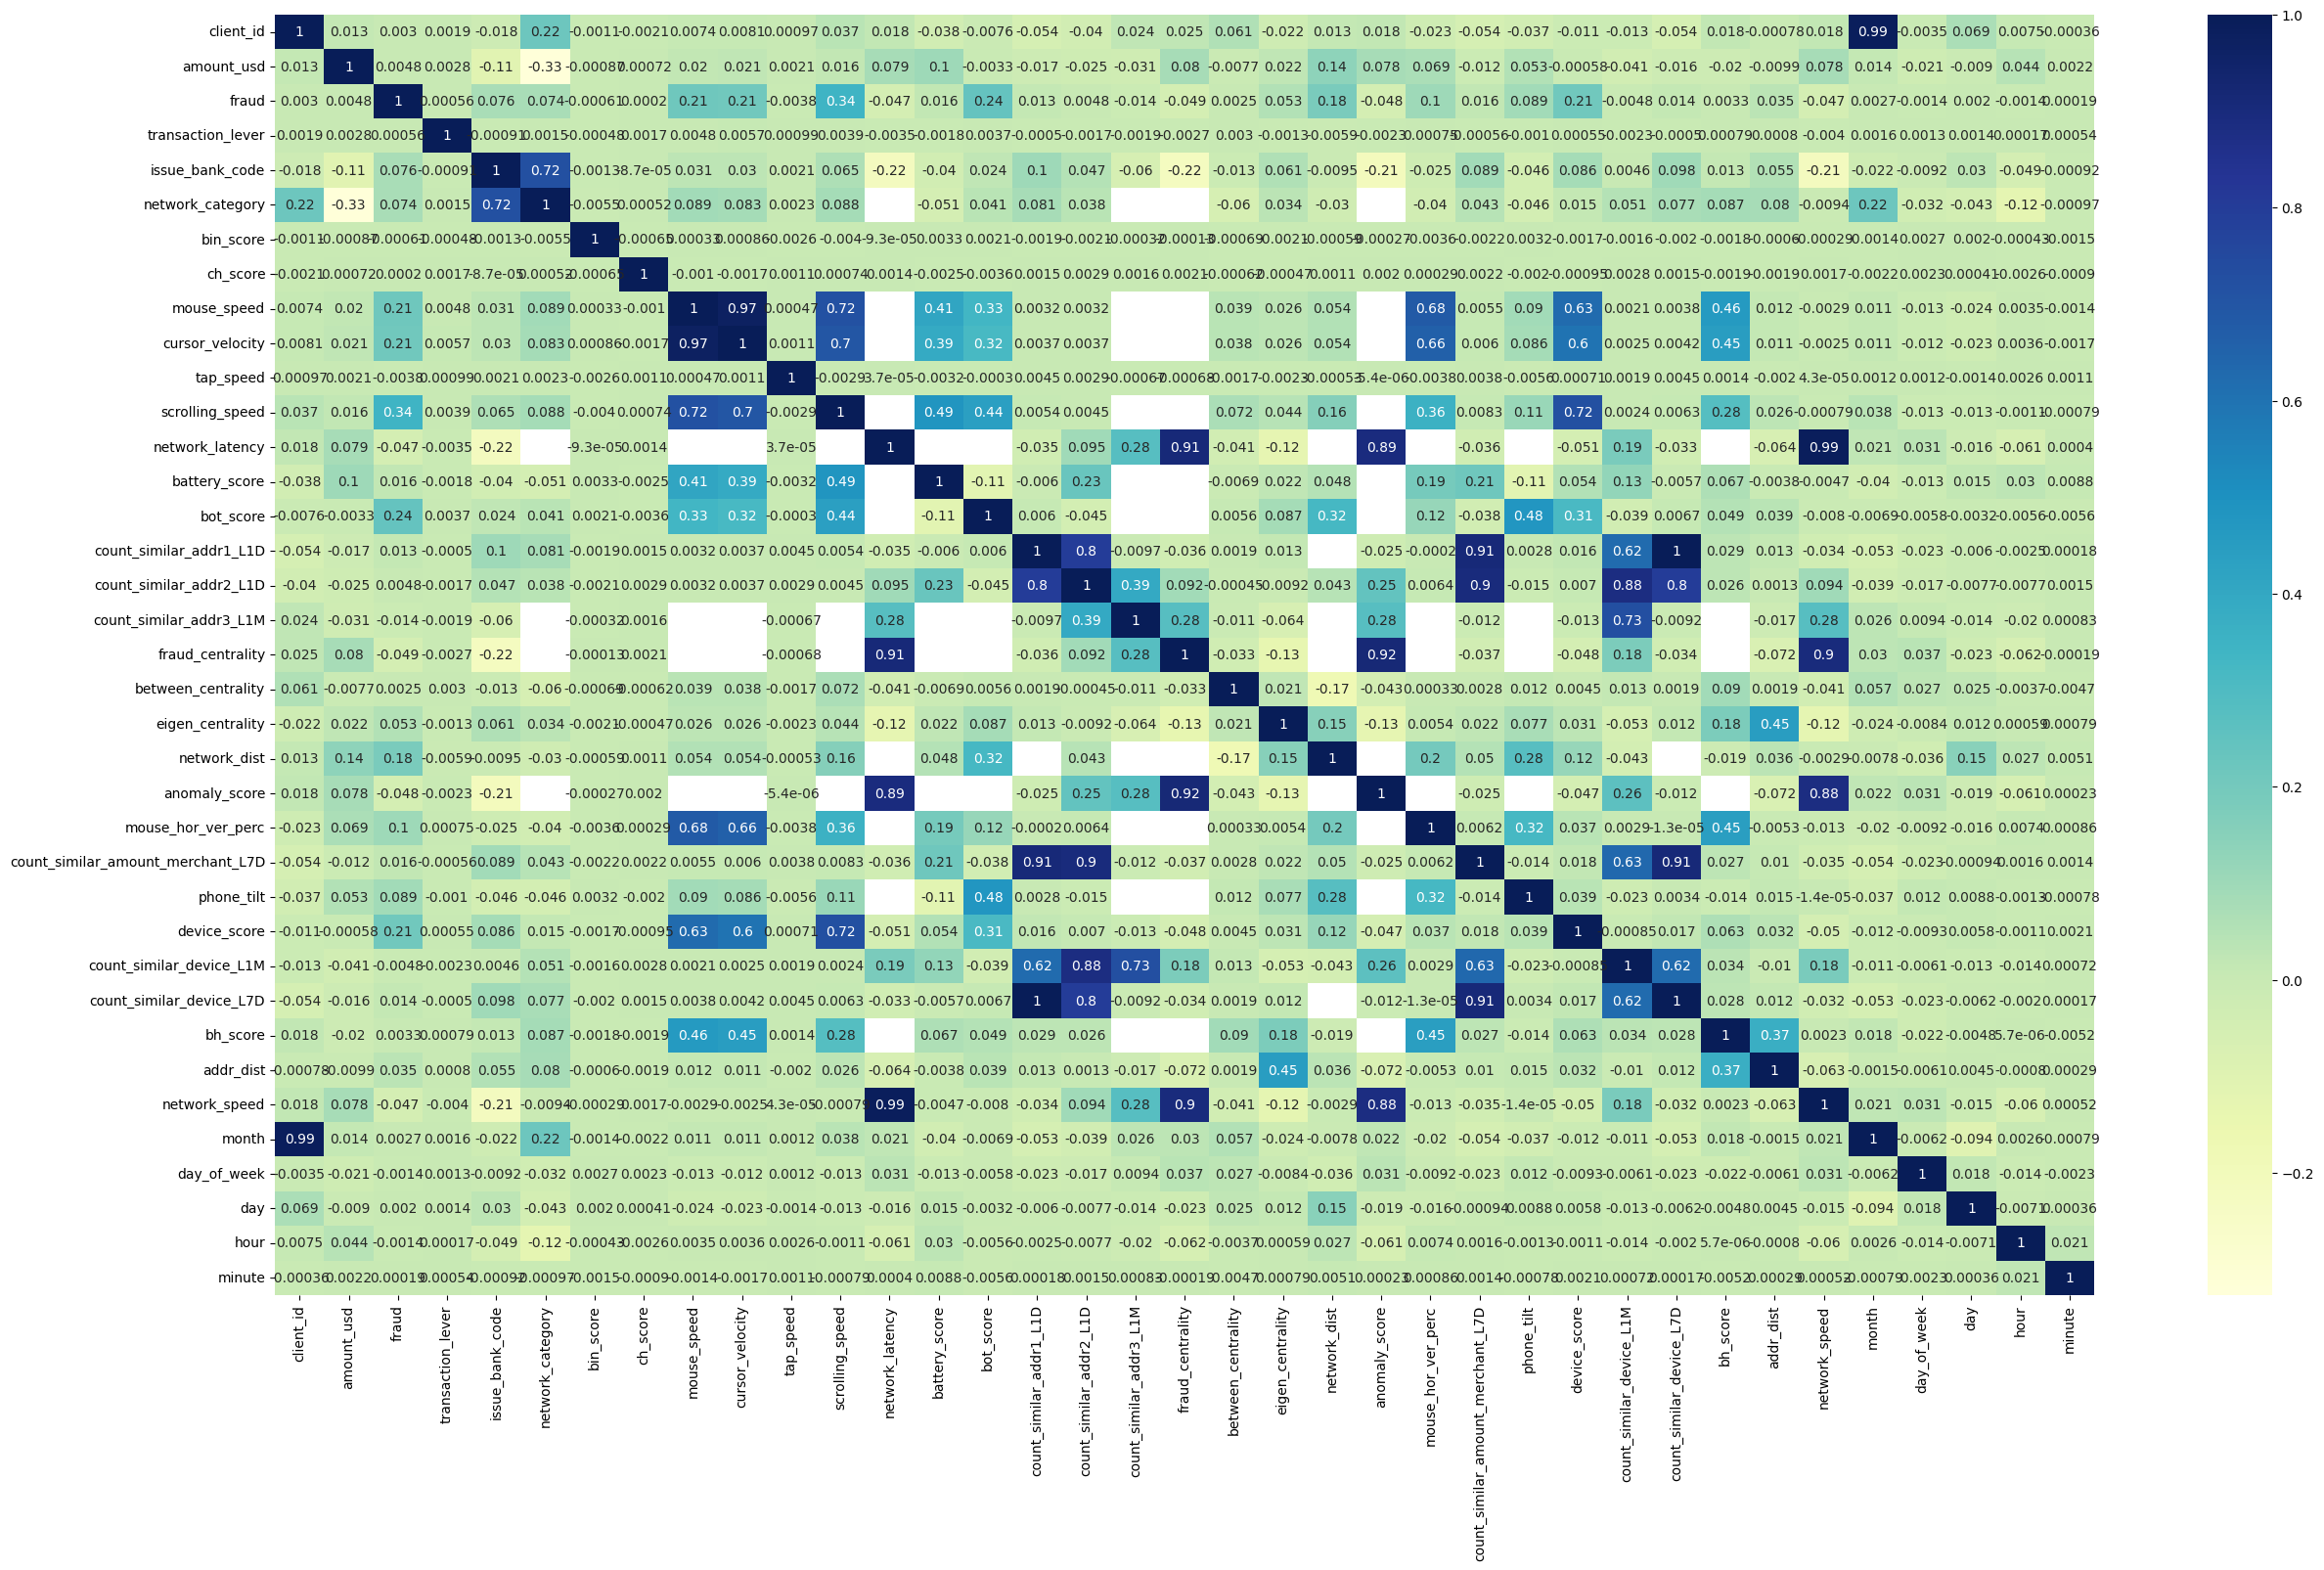

In [9]:
plt.figure(figsize=(30, 17))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='YlGnBu')

**Deleting the columns with correlations above |0.9|**

In [10]:
df = df.drop(columns=["month", "network_latency", "count_similar_device_L7D", "fraud_centrality", "anomaly_score", "count_similar_amount_merchant_L7D", "cursor_velocity"])

In [11]:
# get cat and num features
cat_features = list(df.select_dtypes(include=["object"]).columns)
df[cat_features] = df[cat_features].fillna("missing")
num_features = list(df.select_dtypes(include=["int64", "float64"]).columns)
# df[num_features] = df[num_features].fillna(0)

feature_cols = cat_features + num_features
target = "fraud"
feature_cols.remove(target)

In [12]:
feature_cols

['card_scheme',
 'mcc',
 'country_code',
 'card_type',
 'proxy_ip',
 'client_id',
 'amount_usd',
 'transaction_lever',
 'issue_bank_code',
 'network_category',
 'bin_score',
 'ch_score',
 'mouse_speed',
 'tap_speed',
 'scrolling_speed',
 'battery_score',
 'bot_score',
 'count_similar_addr1_L1D',
 'count_similar_addr2_L1D',
 'count_similar_addr3_L1M',
 'between_centrality',
 'eigen_centrality',
 'network_dist',
 'mouse_hor_ver_perc',
 'phone_tilt',
 'device_score',
 'count_similar_device_L1M',
 'bh_score',
 'addr_dist',
 'network_speed']

<Axes: >

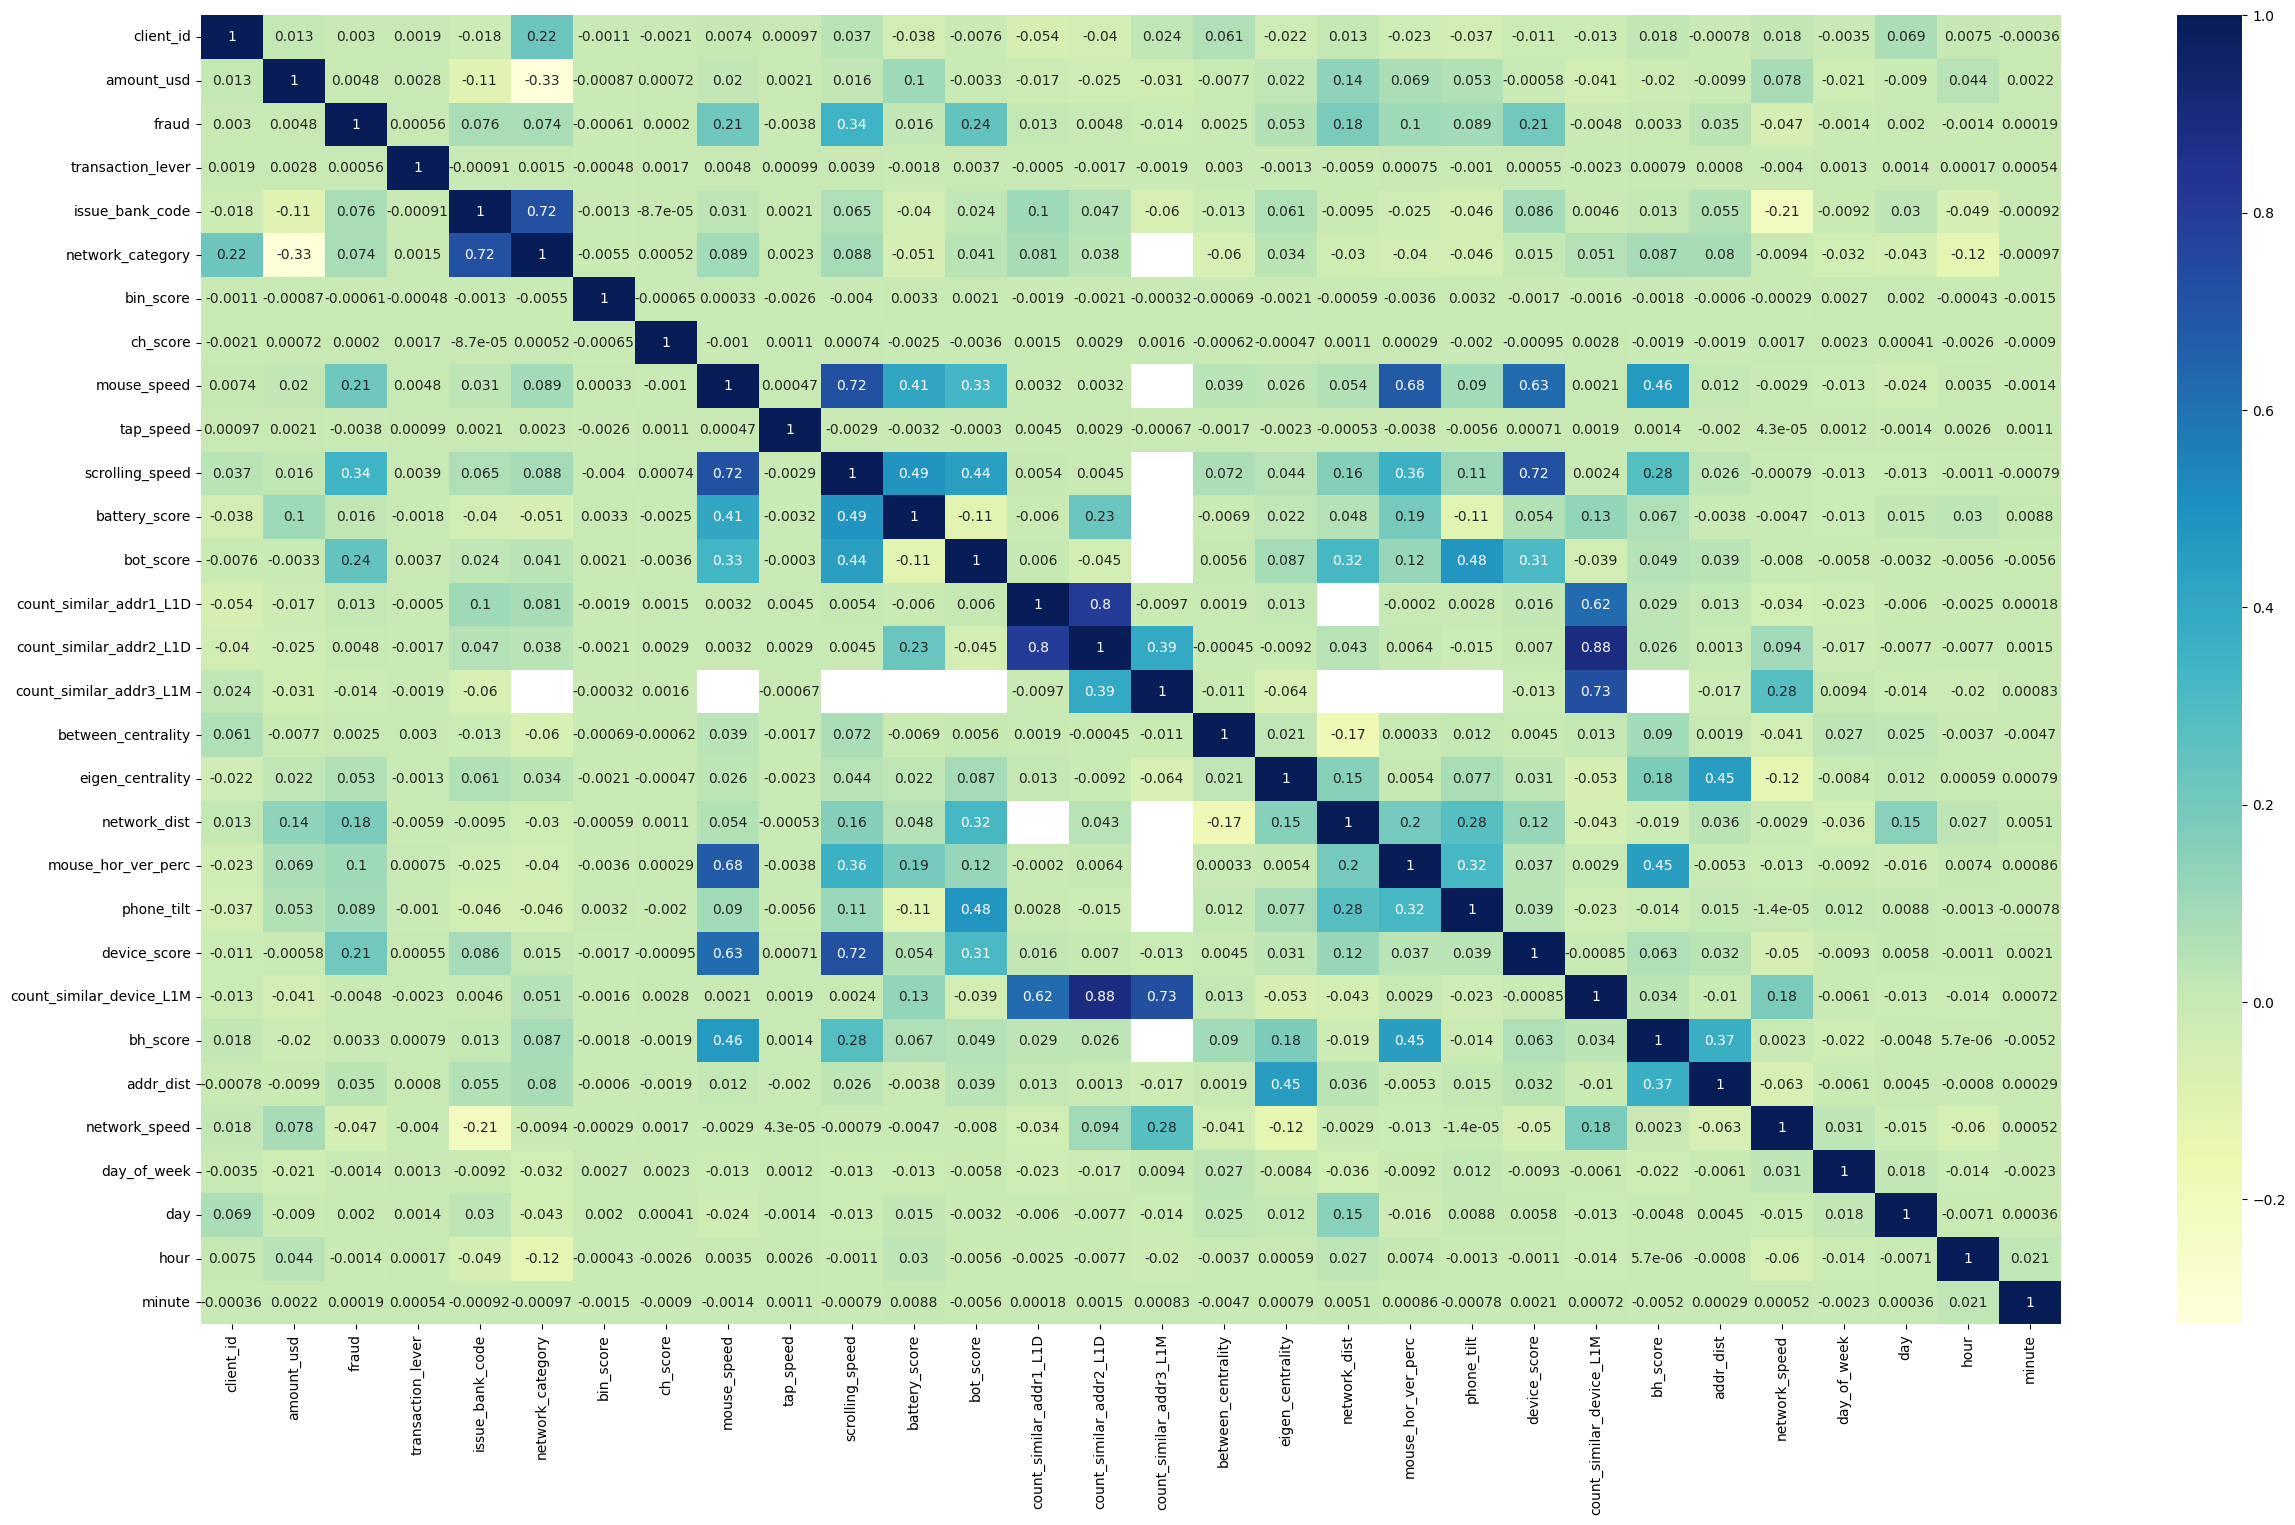

In [13]:
plt.figure(figsize=(30, 17))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='YlGnBu')

In [14]:
shuffled_df = df.sample(frac=1, random_state=42)

In [15]:
df_0 = shuffled_df.loc[shuffled_df.fraud == 0] # fraud bahasy 0-a den bolan rowlar, rows that in fraud equals 0
df_1 = shuffled_df.loc[shuffled_df.fraud == 1] # fraud bahasy 1-a den bolan rowlar, rows that in fraud equals 1

In [16]:
# 500 sany datany test un ayyryp goydym
#for test set I picked 500 row

df_0_test = df_0.iloc[:500]
df_1_test = df_1.iloc[:500]
df_0_train = df_0.iloc[500:]
df_1_train = df_1.iloc[500:]

In [17]:
# concatanated the train and test sets 

train_df = pd.concat([df_0_train, df_1_train]).sample(frac=1, random_state=42)
test_df = pd.concat([df_0_test, df_1_test]).sample(frac=1, random_state=42)

In [18]:
# y as target, X as others

X = train_df.drop(["fraud"], axis=1)
y = train_df["fraud"]
X_test = test_df.drop(["fraud"], axis=1)
y_test = test_df["fraud"]

In [19]:
# fraud imbalansy chozmek :oversampling dine kopyalayar eken shonun un azam bolsa under sample edip ikisinin bahalaryny den geler yaly etdim
# fraud data is imbalanced thats why I used under sampling, because over sampling just copies the data

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [23]:
params = {
        "iterations": 100,
        "early_stopping_rounds": 10,
        "use_best_model": True,
        "random_seed": 42,
        "learning_rate": 0.1        
    }

model = cb.CatBoostClassifier(**params)
model.fit(
        X_train,
        y_train,
        cat_features=cat_features,
        eval_set=[(X_val, y_val)],
        verbose=1000
    )
y_pred = model.predict(X_val)
print(f1_score(y_val, y_pred))

0:	learn: 0.6604666	test: 0.6651097	best: 0.6651097 (0)	total: 221ms	remaining: 21.9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4704570752
bestIteration = 83

Shrink model to first 84 iterations.
0.7741935483870968


In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold =  0
for train_index, val_index in skf.split(X_resampled, y_resampled):
    fold +=1
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
    model = cb.CatBoostClassifier(**params)
    model.fit(
            X_train,
            y_train,
            cat_features=cat_features,
            eval_set=[(X_val, y_val)],
            verbose=1000
        )
    y_pred = model.predict(X_val)
    print(f'The F1 score:{f1_score(y_val, y_pred)}, for the Fold:{fold}')

0:	learn: 0.6639621	test: 0.6626508	best: 0.6626508 (0)	total: 34.1ms	remaining: 3.38s
99:	learn: 0.3846078	test: 0.4693758	best: 0.4693758 (99)	total: 6.84s	remaining: 0us

bestTest = 0.4693758381
bestIteration = 99

The F1 score:0.761081081081081, for the Fold:1
0:	learn: 0.6619902	test: 0.6630246	best: 0.6630246 (0)	total: 50.3ms	remaining: 4.97s
99:	learn: 0.3935412	test: 0.4758101	best: 0.4757207 (95)	total: 5.93s	remaining: 0us

bestTest = 0.4757206831
bestIteration = 95

Shrink model to first 96 iterations.
The F1 score:0.7807486631016043, for the Fold:2
0:	learn: 0.6634419	test: 0.6638600	best: 0.6638600 (0)	total: 40.8ms	remaining: 4.04s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4730947469
bestIteration = 59

Shrink model to first 60 iterations.
The F1 score:0.7794117647058824, for the Fold:3
0:	learn: 0.6615996	test: 0.6649968	best: 0.6649968 (0)	total: 45.8ms	remaining: 4.53s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.479588

In [25]:
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))

0.7842720510095643
